In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#load data
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")


In [3]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [4]:
train = train.loc[(train.item_cnt_day < 2000)]

train.date = train.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))
train.date = train.date.apply(lambda x:dt.datetime.strftime(x,'%Y-%m'))
data = train.groupby(['date','item_id','shop_id']).sum().reset_index()

data = data[['date','item_id','shop_id','item_cnt_day']]

table = pd.pivot_table(data, values='item_cnt_day', index=['item_id', 'shop_id'],
                        columns=['date'], aggfunc=np.sum).reset_index()
table = table.fillna(0)

#get rid of those not in test data
data_inc = test.merge(table, on = ['item_id', 'shop_id'], how = 'left')
data_inc = data_inc.fillna(0)
data_inc = data_inc.iloc[:,3:]



In [5]:
data_inc.columns

Index(['2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10'],
      dtype='object')

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data_inc.values.T)
dataset = dataset.T

print(dataset.shape)
# print(y.shape)

X, y = dataset[:,:33], dataset[:,33:]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
#check shape of x_train and y_train
# reshape input to be [samples, time steps, features]
x_train = x_train.reshape((149940, 33, 1))
y_train = y_train.reshape((149940,1))
x_test = x_test.reshape((64260, 33, 1))
y_test = y_test.reshape((64260,1))

(214200, 34)


In [10]:
batch_size = 1260
look_back = 33
def model_1(): #change neurons
    model = Sequential()
    model.add(LSTM(64, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]),
                   stateful = False))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss='mse', optimizer=adam, metrics=['mean_squared_error'])

    return model

model1 = model_1()

#record training time
start=time.time()
training1=model1.fit(x_train, y_train, batch_size = 1260, epochs = 7, shuffle=False)
end=time.time()
print("--------------------------")
print("Total training time (seconds)", end-start)

# make predictions
trainPredict = model1.predict(x_train, batch_size = 1260)
testPredict = model1.predict(x_test,batch_size = 1260)

#test error
test_rmse = model1.evaluate(x_test, y_test,batch_size = 1260)
print("--------------------------")
print('RMSE' , test_rmse[0])

Epoch 1/7
149940/149940 [==============================] - 52s 345us/step - loss: 0.0609 - mean_squared_error: 0.0609
Epoch 2/7
149940/149940 [==============================] - 53s 352us/step - loss: 0.0604 - mean_squared_error: 0.0604
Epoch 3/7
149940/149940 [==============================] - 51s 341us/step - loss: 0.0603 - mean_squared_error: 0.0603
Epoch 4/7
149940/149940 [==============================] - 52s 346us/step - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 5/7
149940/149940 [==============================] - 52s 346us/step - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 6/7
149940/149940 [==============================] - 52s 350us/step - loss: 0.0601 - mean_squared_error: 0.0601
Epoch 7/7
149940/149940 [==============================] - 52s 347us/step - loss: 0.0601 - mean_squared_error: 0.0601
--------------------------
Total training time (seconds) 364.4282019138336
64260/64260 [==============================] - 8s 121us/step
--------------------------
RMSE 0.0598

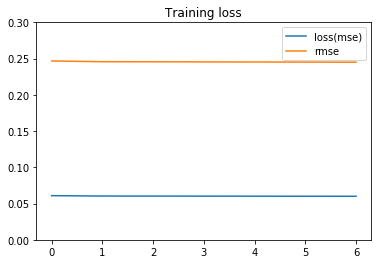

In [11]:
plt.plot(training1.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(training1.history['mean_squared_error']), label= 'rmse')
plt.title('Training loss')
plt.ylim(0,0.3)
plt.legend(loc=1)
plt.show()